In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from utils import sprt_mart, alpha_mart, shrink_trunc, stratum_selector, \
    multinomial_selector, get_global_pvalue, simulate_audits, round_robin, ucb_selector
np.random.seed(123456789)

In [2]:
theta = 1/2 
hand_tally = np.concatenate((np.ones(50), np.zeros(30), np.ones(60), np.zeros(40)))
reported_tally = np.concatenate((np.ones(50), np.zeros(30), np.ones(70), np.zeros(30)))
omega = reported_tally - hand_tally
stratum_indicator = np.concatenate((np.ones(80), 2*np.ones(100)))
u_A = np.ones(2)

A_c = [np.mean(reported_tally[stratum_indicator == 1]), np.mean(reported_tally[stratum_indicator == 1])]
strata = [u_A[0] - omega[stratum_indicator == 1], u_A[1] - omega[stratum_indicator == 2]]

In [7]:
p_value, stratum_selections, null_selections = get_global_pvalue(
    strata = strata, 
    u_A = u_A, 
    A_c = A_c, 
    rule = ucb_selector)

In [4]:
#this is much slower than the R implementation in sweeter-than-sweet
stopping_times = simulate_audits(
    strata = [stratum_1, stratum_2], 
    u = u, 
    v = v, 
    rule = round_robin, 
    n_sims = 30, 
    alpha = .05)

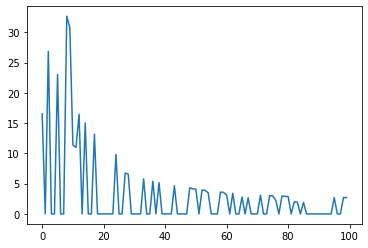

In [11]:
# topography of the P-value of the intersection null at a few sample sizes
rule = ucb_selector
#rule = multinomial_selector
#rule = round_robin

shuffled_1 = np.random.permutation(strata[0])
shuffled_2 = np.random.permutation(strata[1])
N = np.concatenate((np.array([len(shuffled_1)]), np.array([len(shuffled_2)])))
w = N/sum(N)
epsilon = 1 / (2*np.max(N))
raw_theta_1_grid = np.arange(epsilon, u_A[0] - epsilon, epsilon) #sequence from epsilon to u[0] - epsilon
raw_theta_2_grid = (1/2 - w[0] * raw_theta_1_grid) / w[1]
theta_1_grid = raw_theta_1_grid + u_A[0] - A_c[0]
theta_2_grid = raw_theta_2_grid + u_A[1] - A_c[1]

strata_matrix = np.zeros((len(shuffled_1) + len(shuffled_2) - 1, len(theta_1_grid)))
intersection_marts = np.zeros((len(shuffled_1) + len(shuffled_2), len(theta_1_grid)))
for i in range(len(theta_1_grid)):
    mart_1, mu_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = u_A[0], f = .01, u = 2*u_A[0])
    mart_2, mu_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = u_A[1], f = .01, u = 2*u_A[1])
    if rule == ucb_selector:
        lsm_marts_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = theta_1_grid[i]/2, f = .01, u = 2*u_A[0], alternative = "lower")[0]
        lsm_marts_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = theta_2_grid[i]/2, f = .01, u = 2*u_A[1], alternative = "lower")[0]
        lsm_marts = [lsm_marts_1, lsm_marts_2]
    else:
        lsm_marts = None
    strata_matrix[:,i], intersection_marts[:,i] = stratum_selector(
        marts = [mart_1, mart_2],
        mu = [mu_1, mu_2],
        u = 2*u_A,
        lower_sided_marts = lsm_marts,
        rule = rule)
null_index = np.argmin(intersection_marts, axis = 1)
#stratum_selections = strata_matrix[1:sum(N), null_index]
#minimized_martingale = intersection_marts[1:sum(N), null_index]
minimized_martingale = np.ones(sum(N))
stratum_selections = np.ones(sum(N) - 1) * np.inf
for i in np.arange(sum(N) - 1):
    minimized_martingale[i] = intersection_marts[i,null_index[i]]
    stratum_selections[i] = strata_matrix[i,null_index[i]]
maximized_p_values = 1 / np.maximum(1, minimized_martingale)
plt.plot(intersection_marts[10,50:150])

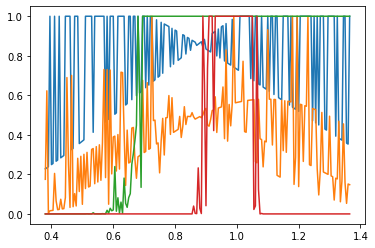

In [12]:
#the below plots are smooth if the rule is round robin, and not at all smooth if it is the intersection martingale
#it might have to do with the fact that different samples are used for every value of theta_1_grid...
#this doesn't happen in the R code: the contours of the intersection martingale are smooth,
#but in that implementation there is no auxiliary randomness
thresholded_marts = intersection_marts
thresholded_marts[intersection_marts < 1] = 1
all_p_values = 1/thresholded_marts
plt.plot(theta_1_grid, all_p_values[1,:], color = 'red')
plt.plot(theta_1_grid, all_p_values[5,:], color = 'bl')
plt.plot(theta_1_grid, all_p_values[30,:])
plt.plot(theta_1_grid, all_p_values[100,:])